In [1]:
# Import libraries
import pandas as pd
import numpy as np
import math
from __future__ import print_function
import cplex
import cyipopt as ipopt
import matplotlib.pyplot as plt

# Years 2020 and 2021

In [2]:
# Complete the following functions
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
    x_optimal = x_init
    cash_optimal = cash_init
    return x_optimal, cash_optimal

def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    '''
    input: initial number of unit/share each assest, initial leftover cash, return estimates, covariance estimates, price at that day
    output: optimal number of unit/share each assest, leftover cash after rebalance
    '''
    # total number of stocks
    n = 20
    # initial portfolio value
    port_value = np.dot(cur_prices,x_init) + cash_init
    # asset weight is 1/n, each asset value is 1/n * total value
    x_optimal = np.floor(np.ones((20))/20 * port_value / cur_prices)
    # transaction cost is 0.5% of the traded volume
    tran_cost = 0.005 * np.dot(cur_prices , abs(x_optimal-x_init))
    # cash flow is the difference btw
    # portfolio value before re-balancing and 
    # value of portfolio after re-balancing plus the transaction fees
    cash_optimal = port_value - (np.dot(cur_prices,x_optimal) + tran_cost)

    return x_optimal, cash_optimal


def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
    # total number of stocks
    n = 20
    # Initialize CPLEX object
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    # we dont have linear part of objective function for variance
    c  = [0.0] * n
    # bounds on variables weight 1-20, each weight should between (0,1)
    ub = [1.0] * n
    lb = [0.0] * n
    # Define constraints cols and add right-hand-side of constraints
    cols = [[[0, 1], [1, 0]],[[0, 1], [1, 0]]]*10
    # want sum(x1,x20)=1
    cpx.linear_constraints.add(rhs=[1.0, 0.0], senses="EE")
    # Add linear part of objective function, bounds on variables, and linear constraints to CPLEX model
    cpx.variables.add(obj=c, ub=ub, lb=lb, columns=cols,
                  names=["w1","w2","w3","w4","w5","w6","w7","w8","w9","w10",
                         "w11","w12","w13","w14","w15","w16","w17","w18","w19","w20"])
    # Add quadratic part of objective variance function to CPLEX model
    # covariance matrix is 20x20, we want to sum(ρijσiσjwiwj) for each ij
    qmat = []
    for i in range(n):
        qmat.append([list(range(n)),list(2*Q[i,:])])
    cpx.objective.set_quadratic(qmat)
    # Set CPLEX parameters
    alg = cpx.parameters.lpmethod.values
    cpx.parameters.qpmethod.set(alg.concurrent)
    # disable output to screen
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    # optimization
    cpx.solve()
    
    # asset weight
    w_opt = np.array(cpx.solution.get_values())
    # initial portfolio value
    port_value = np.dot(cur_prices,x_init) + cash_init
    # each asset value is wi * total value
    x_optimal = np.floor(w_opt * port_value / cur_prices)
    # transaction cost is 0.5% of the traded volume
    tran_cost = 0.005 * np.dot(cur_prices , abs(x_optimal-x_init))
    # cash flow is the difference btw
    # portfolio value before re-balancing and 
    # value of portfolio after re-balancing plus the transaction fees
    cash_optimal = port_value - (np.dot(cur_prices,x_optimal) + tran_cost)

    return x_optimal, cash_optimal

def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    # Annual risk-free rate for years 2020-2021 is 2.5%
    # Annual risk-free rate for years 2008-2009 is 4.5%
    # Annual risk-free rate for year 2022 is 3.75%

    if cur_year == 2022:
        rf_ann = 0.0375
    elif cur_year ==  2008:
        rf_ann = 0.045
    else:
        rf_ann = 0.025
    if cur_year == 2022:
        # number of trading days in 2022 is 45 to 295
        rf = rf_ann/250
    else:
        # number of trading days in 2020 is from row 43 to 295
        rf = rf_ann/(295-43)
    # optimize 20 y, 1 k
    n = 21
    # Initialize CPLEX object
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    # we dont have linear part of objective function for variance
    c  = [0.0] * n
    # bounds on variables y1-y20, k, should be larger than 0
    ub = [np.inf] * n
    lb = [0.0] * n
    # define additional return
    add_ret = mu-rf * np.ones(20)
    # Define constraints cols and add right-hand-side of constraints
    # sum(add_ret * yi) = 1
    # sum(yi) - k = 0
    cols = []
    for k in range(n-1):
        cols.append([[0, 1],[add_ret[k], 1]])
    cols.append([[0, 1],[0, -1]])
    cpx.linear_constraints.add(rhs=[1.0, 0.0], senses="EE")
    # Add linear part of objective function, bounds on variables, and linear constraints to CPLEX model
    var_names = ["y_%s" % i for i in range(1,n)]
    var_names.append('k')
    cpx.variables.add(obj=c, ub=ub, lb=lb, columns=cols, names=var_names)
    
    # modify Q to add risk free, Q_new is 21 x 21
    Q1 = np.append(Q,np.zeros((20,1)),axis=1)
    Q_new = np.vstack([Q1,np.zeros((21))])
    # Add quadratic part of objective variance function to CPLEX model
    # covariance matrix is 21x21, we want to sum(ρijσiσjyiyj) for each ij
    qmat = []
    for i in range(n):
        qmat.append([list(range(n)),list(2*Q_new[i,:])])
    cpx.objective.set_quadratic(qmat)
    # Set CPLEX parameters
    alg = cpx.parameters.lpmethod.values
    cpx.parameters.qpmethod.set(alg.concurrent)
    # disable output to screen
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    # optimization
    cpx.solve()
    # initial portfolio value
    port_value = np.dot(cur_prices,x_init) + cash_init
    
    if cpx.solution.get_status_string()== 'infeasible':
        x_optimal = x_init
        cash_optimal = cash_init
        w_opt = (x_init*cur_prices)/port_value
    else:
        
        # optimized y and k
        y = np.array(cpx.solution.get_values())
        # optimized weight w=y/k
        w_opt = y[:20]/y[20]
        # each asset value is wi * total value
        x_optimal = np.floor(w_opt * port_value / cur_prices)
        # transaction cost is 0.5% of the traded volume
        tran_cost = 0.005 * np.dot(cur_prices , abs(x_optimal-x_init))
        # cash flow is the difference btw
        # portfolio value before re-balancing and 
        # value of portfolio after re-balancing plus the transaction fees
        cash_optimal = port_value - (np.dot(cur_prices,x_optimal) + tran_cost)

    return x_optimal, cash_optimal


### Equal risk contribution (ERC) portfolio

\begin{equation}
 \begin{array}{rll}
  \displaystyle \min_{w} & \displaystyle \sum_{i=1}^n \sum_{j=1}^n \left( w_i (Qw)_i - w_j (Qw)_j \right)^2 \\
  \mbox{s.t.} & \sum_{i=1}^n w_i = 1 \\
  & w \geq 0
 \end{array}
\end{equation}

In [3]:
# Define objective function, constraints, 
# gradient of objective fucntion, and jacobian of constrants for the ERC problem.
n=20
class erc(object):
    def __init__(self):
        pass

    def objective(self, x):
        # The callback for calculating the objective
        y = x * np.dot(Q, x)
        fval = 0
        for i in range(20):
            for j in range(i,20):
                xij = y[i] - y[j]
                fval = fval + xij*xij
        fval = 2*fval
        return fval

#     def gradient(self, x):
#         # The callback for calculating the gradient
#         grad = np.zeros(n)
#         y = x * np.dot(Q, x)
#         # Insert your gradient computations here
#         for i in range(20):
#             for j in range(i,20):
#                 gij = (y[i]-y[j]) * (Q[i].dot(x) + Q[i,i] * x[i] - Q[i,j] * x[i])
#                 grad[i]+=2*gij
#             grad[i]*=2
#         # You can use finite differences to check the gradient
#         return grad
    
    def gradient(self, x):
        # The callback for calculating the gradient
        grad = np.zeros(n)
        y = x * np.dot(Q, x)
        # Insert your gradient computations here
        for ii in range(20):
            # gradient for each stock
            for i in range(20):
                for j in range(i,20):
                    if ii == i:
                        gij = (y[i]-y[j]) * (Q[i].dot(x) + Q[i,i] * x[i] - Q[j,i] * x[j])
                    else:
                        gij = (y[i]-y[j]) * (Q[i,ii] * x[i] - Q[j,ii] * x[j])
                    grad[i]+=2*gij
            grad[ii]*=2
        # You can use finite differences to check the gradient
        return grad

    def constraints(self, x):
        # The callback for calculating the constraints
        return [1.0] * n
    
    def jacobian(self, x):
        # The callback for calculating the Jacobian
        return np.array([[1.0] * 20])


In [4]:

def strat_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):
    # initial portfolio value
    port_value = np.dot(cur_prices,x_init) + cash_init
    n = 20 # num of stocks
    lb = [0.0] * n  # lower bounds on variables
    ub = [1.0] * n  # upper bounds on variables
    cl = [1]        # lower bounds on constraints
    cu = [1]        # upper bounds on constraints
    w0 = [1.0/n] * n # initial Weights of "1/n" portfolio

    # Define IPOPT problem
    nlp = ipopt.Problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)
 
    # Set the IPOPT options
    nlp.add_option('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.add_option('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.add_option('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.add_option('tol'.encode('utf-8'), 1e-10)
    nlp.add_option('print_level', 0)

    

    # Solve the problem
    w_erc, info = nlp.solve(w0)

#     print("\nOptimal solution: w = %s\n" % repr(w_erc))
#     print("Objective function value = %s\n" % repr(info['obj_val']))
    
    # each asset value is wi * total value
    x_optimal = np.floor(w_erc * port_value / cur_prices)
    # transaction cost is 0.5% of the traded volume
    tran_cost = 0.005 * np.dot(cur_prices , abs(x_optimal-x_init))
    # cash flow is the difference btw
    # portfolio value before re-balancing and 
    # value of portfolio after re-balancing plus the transaction fees
    cash_optimal = port_value - (np.dot(cur_prices,x_optimal) + tran_cost)

    return x_optimal, cash_optimal


In [5]:
def strat_lever_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):
    # Annual risk-free rate for years 2020-2021 is 2.5%
    # Annual risk-free rate for years 2008-2009 is 4.5%
    # Annual risk-free rate for year 2022 is 3.75%

    if cur_year == 2022:
        r_rf = 0.0375
    elif cur_year ==  2008:
        r_rf = 0.045
    else:
        r_rf = 0.025
        
    # initial portfolio value
    port_value = np.dot(cur_prices,x_init) + cash_init
    #interest for one period
    interest = (r_rf/6) * init_value
    if period == 1:
        port_value += init_value
        
    n = 20 # num of stocks
    lb = [0.0] * n  # lower bounds on variables
    ub = [1.0] * n  # upper bounds on variables
    cl = [1]        # lower bounds on constraints
    cu = [1]        # upper bounds on constraints
    w0 = [1.0/n] * n # initial Weights of "1/n" portfolio
    
    # Define IPOPT problem
    nlp = ipopt.Problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)
 
    # Set the IPOPT options
    nlp.add_option('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.add_option('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.add_option('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.add_option('tol'.encode('utf-8'), 1e-10)
    nlp.add_option('print_level', 0)

    # Solve the problem
    w_erc, info = nlp.solve(w0)
#     print(w_erc)
#     w_erc = np.array(w_erc)
#     w_erc = w_erc*(1/w_erc.sum())
#     print(w_erc)
    # each asset value is wi * total value
    x_optimal = np.floor(w_erc * port_value / cur_prices)
    # transaction cost is 0.5% of the traded volume
    tran_cost = 0.005 * np.dot(cur_prices , abs(x_optimal-x_init))
    # cash flow is the difference btw
    # portfolio value before re-balancing and 
    # value of portfolio after re-balancing plus the transaction fees
    cash_optimal = port_value - interest - (np.dot(cur_prices,x_optimal) + tran_cost)

    return x_optimal, cash_optimal

### Define and solve CPLEX robust mean-variance model 

\begin{equation}
  \begin{array}{lll}
    \min   & w^TQw       \\
    {\rm s.t.} & \begin{array}[t]{@{\hspace{0cm}}r@{\hspace{0.1cm}}c@{\hspace{0.1cm}}ll}
          \sum_{i=1}^n w_i & = & 1  \\
          \mu^T w & \geq & \varepsilon_{\rm ret} \\
          w^T \Theta w & \leq & \tilde{\varepsilon}_{\rm rob} \\
            w & \geq & 0
     \end{array}
  \end{array}
\end{equation}

In [6]:
def strat_robust_optim(x_init, cash_init, mu, Q, cur_prices):
    # Annual risk-free rate for years 2020-2021 is 2.5%
    # Annual risk-free rate for years 2008-2009 is 4.5%
    # Annual risk-free rate for year 2022 is 3.75%

    if cur_year == 2022:
        r_rf = 0.0375
    elif cur_year ==  2008:
        r_rf = 0.045
    else:
        r_rf = 0.025
    # daily rate
    if cur_year == 2022:
        rf=r_rf/250
    else:
        rf = r_rf/(295-43)

    Portf_Retn = rf
    # define cplex model
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    # we dont have linear part of objective function for variance
    c  = [0.0] * n
    # bounds on variables weight 1-20, each weight should between (0,1)
    lb = [0.0] * n
    ub = [1.0] * n
    # Define constraints cols and add right-hand-side of constraints
    A = []
    for k in range(n):
        A.append([[0,1],[1.0,mu[k]]])
    var_names = ["w_%s" % i for i in range(1,n+1)]
    cpx.linear_constraints.add(rhs=[1.0,Portf_Retn], senses="EG")
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(Qmat)
    # Required portfolio robustness
    var_matr = np.diag(np.diag(Q))
    # Target portfolio return estimation error is return estimation error of 1/n portfolio
    w0 = [1.0/n] * n # initial Weights of "1/n" portfolio
    rob_init = np.dot(w0, np.dot(var_matr, w0)) # return estimation error of initial portfolio
    rob_bnd  = rob_init # target return estimation error
    Qcon = cplex.SparseTriple(ind1=var_names, ind2=range(n), val=np.diag(var_matr))
    cpx.quadratic_constraints.add(rhs=rob_bnd, quad_expr=Qcon, name="Qc")
    # Setting number of threads to 4
    cpx.parameters.threads.set(4)
    # Setting timelimit 60
    cpx.parameters.timelimit.set(60)
    # Setting Barrier algorithm convergence tolerance 1e-12
    cpx.parameters.barrier.qcpconvergetol.set(1e-12)
    # Disable CPLEX output to screen
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()
    # initial portfolio value
    port_value = np.dot(cur_prices,x_init) + cash_init
    if cpx.solution.get_status_string()== 'infeasible':
        x_optimal = x_init
        cash_optimal = cash_init
        w_opt = (x_init*cur_prices)/port_value
    else:
        w_rMV = cpx.solution.get_values()
       
        # each asset value is wi * total value
        x_optimal = np.floor(np.array(w_rMV) * port_value / cur_prices)
        # transaction cost is 0.5% of the traded volume
        tran_cost = 0.005 * np.dot(cur_prices , abs(x_optimal-x_init))
        # cash flow is the difference btw
        # portfolio value before re-balancing and 
        # value of portfolio after re-balancing plus the transaction fees
        cash_optimal = port_value - (np.dot(cur_prices,x_optimal) + tran_cost)

    return x_optimal, cash_optimal

## 2. Analyze your results:
### Produce output for the 12 periods (years 2020 and 2021)

In [7]:
# Input file
input_file_prices = 'Daily_closing_prices.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2019 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2019)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2019
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2020-2021 is 2.5%
r_rf = 0.025
# Annual risk-free rate for years 2008-2009 is 4.5%
r_rf2008_2009 = 0.045
# Annual risk-free rate for year 2022 is 3.75%
r_rf2022 = 0.0375

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
N_strat = 7  # comment this in your code
#N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_equal_risk_contr, strat_robust_optim]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 20:
       cur_year  = 20 + math.floor(period/7)
   else:
       cur_year  = 2020 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      ###################### Insert your code here ############################

      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      # modify portfolio value for leverage equal risk
      if strategy == 5:
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1)) - init_value
      else:
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
        
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))

      
   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)

# Plot results
###################### Insert your code here ############################



Initial portfolio value = $ 1000012.93


Period 1: start date 01/02/2020, end date 02/28/2020
  Strategy "Buy and Hold", value begin = $ 1000012.93, value end = $ 893956.75
  Strategy "Equally Weighted Portfolio", value begin = $ 990847.26, value end = $ 892113.20
  Strategy "Mininum Variance Portfolio", value begin = $ 992722.33, value end = $ 915686.37
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990013.60, value end = $ 921430.84

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

  Strategy "Equal Risk Contributions Portfolio", value begin = $ 991347.66, value end = $ 898553.53
  Strategy "Leveraged Equal Risk Contributions Portfolio", 

  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 1830369.21, value end = $ 1865775.95
  Strategy "Robust Optimization Portfolio", value begin = $ 1397674.37, value end = $ 1367046.33

Period 12: start date 11/01/2021, end date 12/31/2021
  Strategy "Buy and Hold", value begin = $ 951350.41, value end = $ 932471.35
  Strategy "Equally Weighted Portfolio", value begin = $ 1583499.82, value end = $ 1645256.61
  Strategy "Mininum Variance Portfolio", value begin = $ 1053865.17, value end = $ 1047948.73
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 2123737.56, value end = $ 2229411.63
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 1469097.38, value end = $ 1521981.13
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 1882388.82, value end = $ 1986292.51
  Strategy "Robust Optimization Portfolio", value begin = $ 1360433.85, value end = $ 1390792.33


### Plot one chart in Python that illustrates the daily value of your portfolio

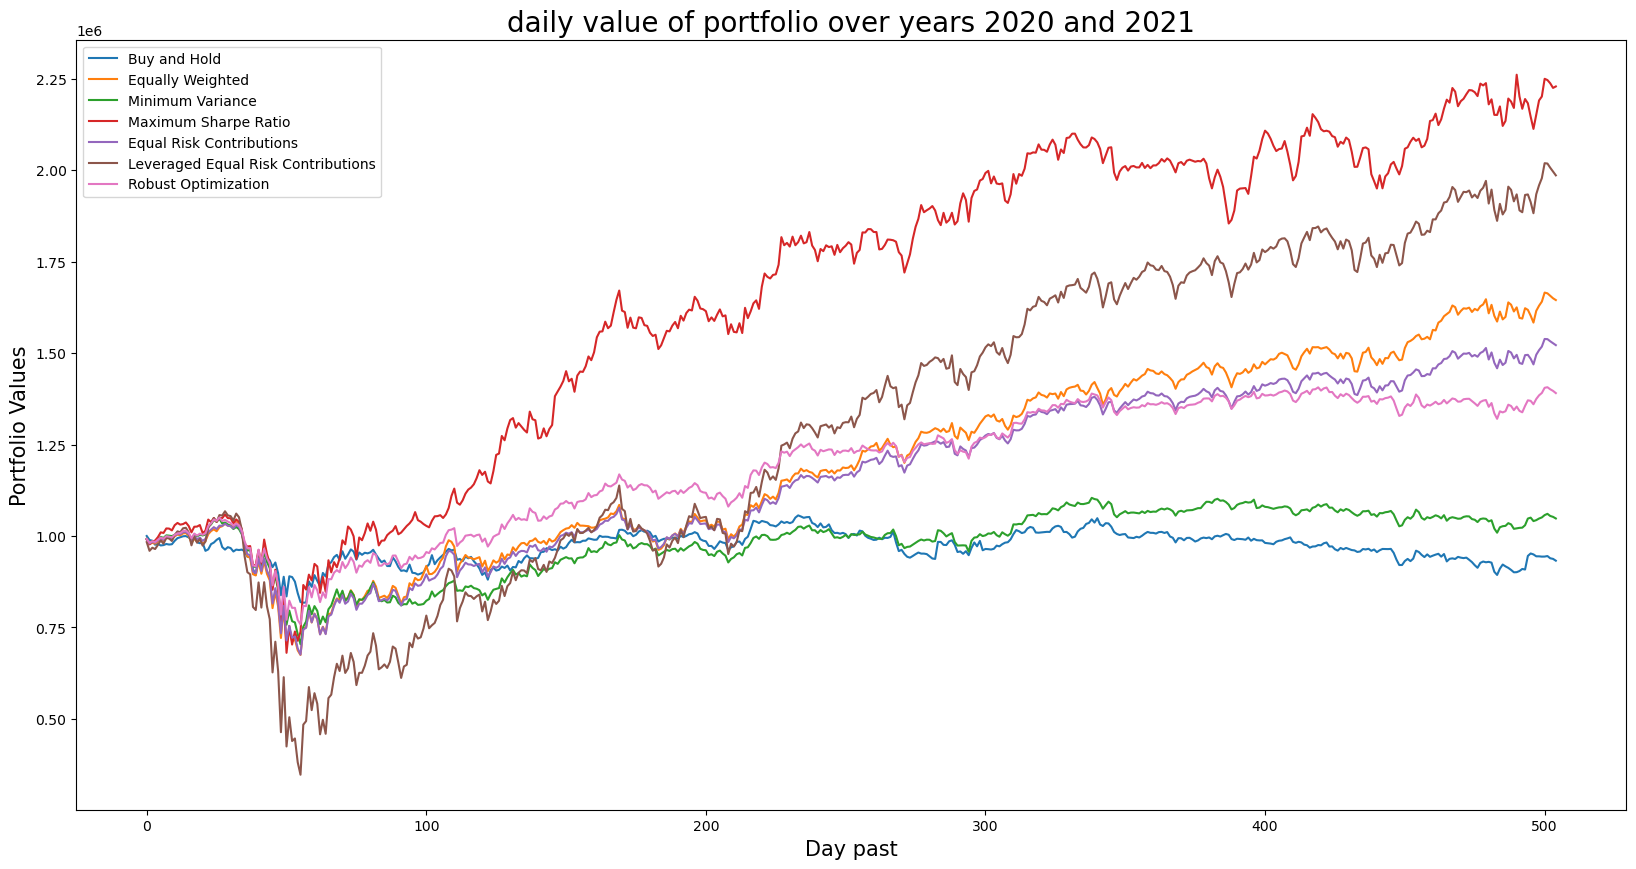

In [8]:
plt.figure(figsize=(20,10))
plt.plot(portf_value[0],label='Buy and Hold')
plt.plot(portf_value[1],label='Equally Weighted')
plt.plot(portf_value[2],label='Minimum Variance')
plt.plot(portf_value[3],label='Maximum Sharpe Ratio')
plt.plot(portf_value[4],label='Equal Risk Contributions')
plt.plot(portf_value[5],label='Leveraged Equal Risk Contributions')
plt.plot(portf_value[6],label='Robust Optimization')
plt.title('daily value of portfolio over years 2020 and 2021',fontsize=20)
plt.xlabel('Day past',fontsize=15)
plt.ylabel('Portfolio Values',fontsize=15)
plt.legend()
plt.show()

### Maximum drawdown

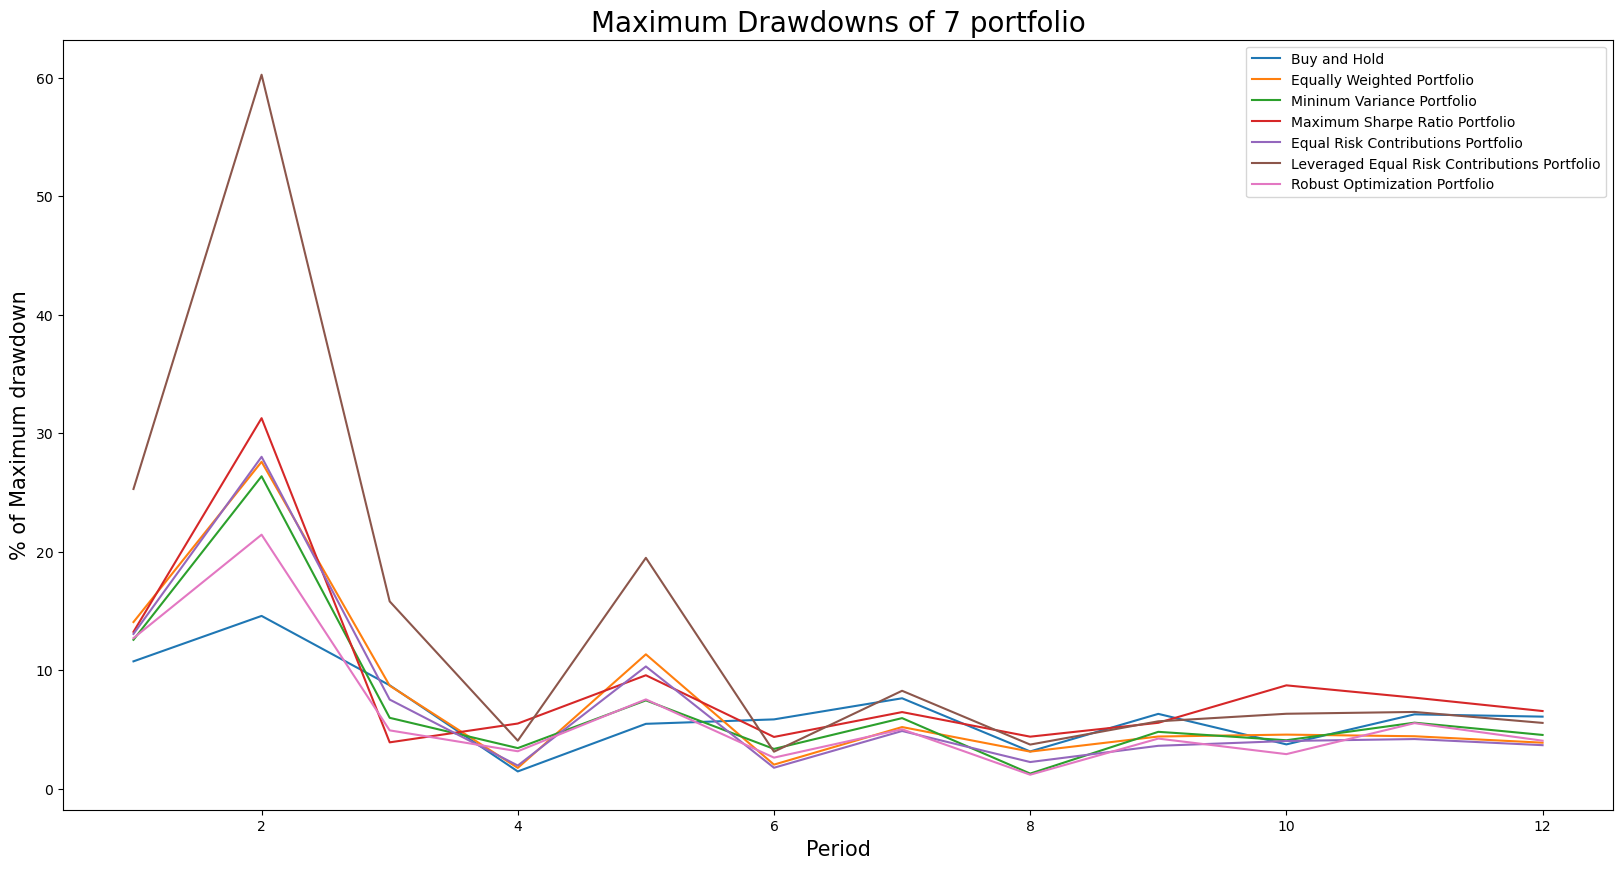

In [9]:
# dataframe of daily value of 7 portfolio
day_value = pd.DataFrame(portf_value[0].flatten())
for i in range(1,7):
    day_value[str(i)] = portf_value[i].flatten()
# seperate by period
period_value = []
for p in range(12):
    period_value.append(day_value.loc[504/12 * p : 504/12 * (p+1)])
# maximum drawdown
md_value = []
for p in range(12):
    dd_p = []
    for s in range(7):
        if s == 0:
            dd = (((period_value[p].loc[:,s] - period_value[p].loc[:,s].expanding().max()) / period_value[p].loc[:,s].expanding().max())*100).abs()
        else:
            dd = (((period_value[p].loc[:,str(s)] - period_value[p].loc[:,str(s)].expanding().max()) / period_value[p].loc[:,str(s)].expanding().max())*100).abs()
        dd_p.append(dd.max())
    md_value.append(dd_p)

# plot
columns=['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
plt.figure(figsize=(20,10))
for s in range(7):
    plt.plot(range(1, 13),np.array(md_value).transpose()[s],label=columns[s])

plt.title('Maximum Drawdowns of 7 portfolio',fontsize=20)
plt.xlabel('Period', fontsize=15)
plt.ylabel('% of Maximum drawdown', fontsize=15)
plt.legend()
plt.show()
# columns=['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']

### Plot one chart in Python to show dynamic changes in portfolio allocations under strategy 7.

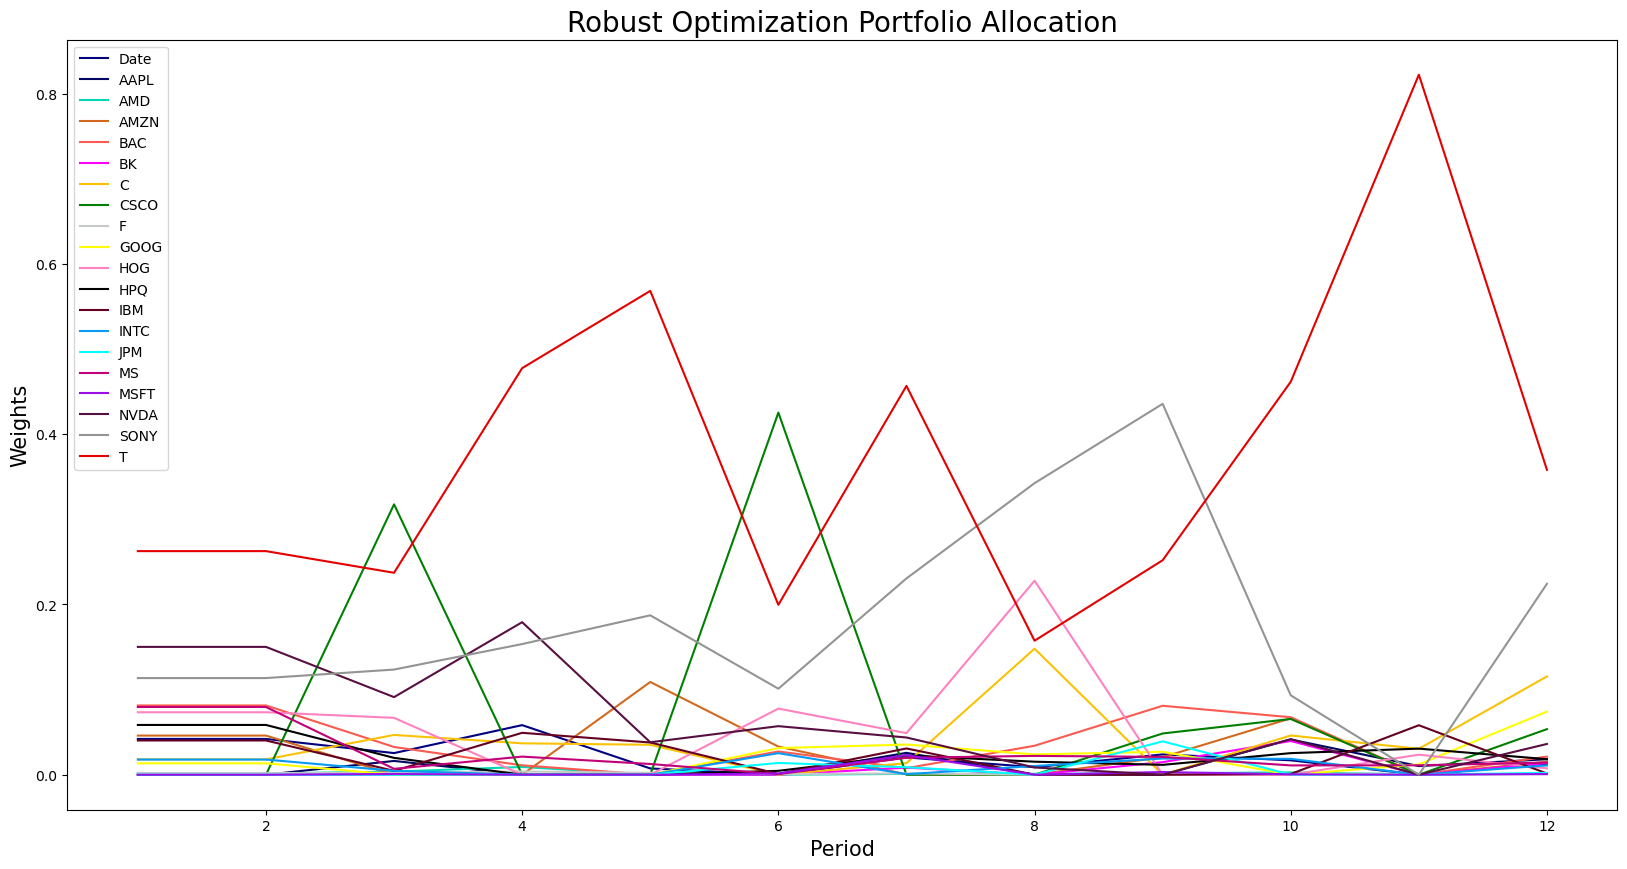

In [10]:
plt.figure(figsize=(20,10))
# self assign different color to each stock
c_list=['#000080','#030764','#04D8B2','#D2691E','#FC5A50','#FF00FF','#FAC205','#008000','#C5C9C7','#FFFF00','#FF81C0','#000000','#650021','#069AF3','#00FFFF','#C20078','#9A0EEA','#580F41','#929591','#E50000','#9A0EEA']

for stock in range(20):
    # we want to store weight of each stock 1-20 for 12 periods
    w_period = []
    for period in range(1, N_periods+1):
        # strategy 7 at index 6
        w_all = x[6, period-1]/sum(x[6, period-1])
        w_period.append(w_all[stock])
    plt.plot(range(1, N_periods+1),w_period,label=df.columns[stock],color=c_list[stock])

plt.title('Robust Optimization Portfolio Allocation',fontsize=20)
plt.xlabel('Period',fontsize=15)
plt.ylabel('Weights',fontsize=15)
plt.legend()
plt.show()

## 3. Test your trading strategies for years 2008 and 2009:
### Produce output for the 12 periods (years 2008 and 2009)

In [11]:
# Input file
input_file_prices = 'Daily_closing_prices20082009.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2007 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2007)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2007
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2020-2021 is 2.5%
r_rf = 0.025
# Annual risk-free rate for years 2008-2009 is 4.5%
r_rf2008_2009 = 0.045
# Annual risk-free rate for year 2022 is 3.75%
r_rf2022 = 0.0375

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
N_strat = 7  # comment this in your code
#N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_equal_risk_contr, strat_robust_optim]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 8:
       cur_year  = 8 + math.floor(period/7)
   else:
       cur_year  = 2008 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      ###################### Insert your code here ############################
      if cash[strategy, period-1] < 0:
            # propotion of each stock unit of share to total unit of share
            propotion = x[strategy, period-1] / sum(x[strategy, period-1])
            # value deduction of each stock
            v_deduction = abs(cash[strategy, period-1]) * propotion
            # unit of share deduction of each stock
            x_deduction = np.ceil(v_deduction/cur_prices)
            # deduct the share from optimal bunch
            x[strategy, period-1] = x[strategy, period-1] - x_deduction
            # new cost - transaction cost is 0.5% of the traded volume
            new_cost = 0.005 * np.dot(cur_prices , abs(x[strategy, period-1]-curr_positions))
            # total portfolio value
            if cash[5,0]<0:
                port_value = 2*(np.dot(cur_prices,curr_positions) + curr_cash)
            else:
                port_value = np.dot(cur_prices,curr_positions) + curr_cash
            # modify cash - cash flow is the difference btw
            # portfolio value before re-balancing and 
            # value of portfolio after re-balancing plus the transaction fees
            cash[strategy, period-1] = port_value - (np.dot(cur_prices,x[strategy, period-1]) + new_cost)
        

      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      # modify portfolio value for leverage equal risk
      if strategy == 5:
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1)) - init_value
      else:
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
        
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))

      
   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)



Initial portfolio value = $ 385097.15


Period 1: start date 01/02/2008, end date 02/29/2008
  Strategy "Buy and Hold", value begin = $ 385097.15, value end = $ 325918.34
  Strategy "Equally Weighted Portfolio", value begin = $ 381649.89, value end = $ 326929.57
  Strategy "Mininum Variance Portfolio", value begin = $ 383262.32, value end = $ 327133.76
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 381265.54, value end = $ 332652.59
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 381843.80, value end = $ 329237.58
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 380219.95, value end = $ 274975.71
  Strategy "Robust Optimization Portfolio", value begin = $ 382119.84, value end = $ 324780.73

Period 2: start date 03/03/2008, end date 04/30/2008
  Strategy "Buy and Hold", value begin = $ 325807.08, value end = $ 349997.20
  Strategy "Equally Weighted Portfolio", value begin = $ 322097.69, value end = $ 354821.22
  Strategy "Mininum

  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 185539.21, value end = $ 209901.43
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 331002.07, value end = $ 369925.36
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 277966.26, value end = $ 355640.82
  Strategy "Robust Optimization Portfolio", value begin = $ 316472.33, value end = $ 353821.11


### Plot one chart in Python that illustrates the daily value of your portfolio

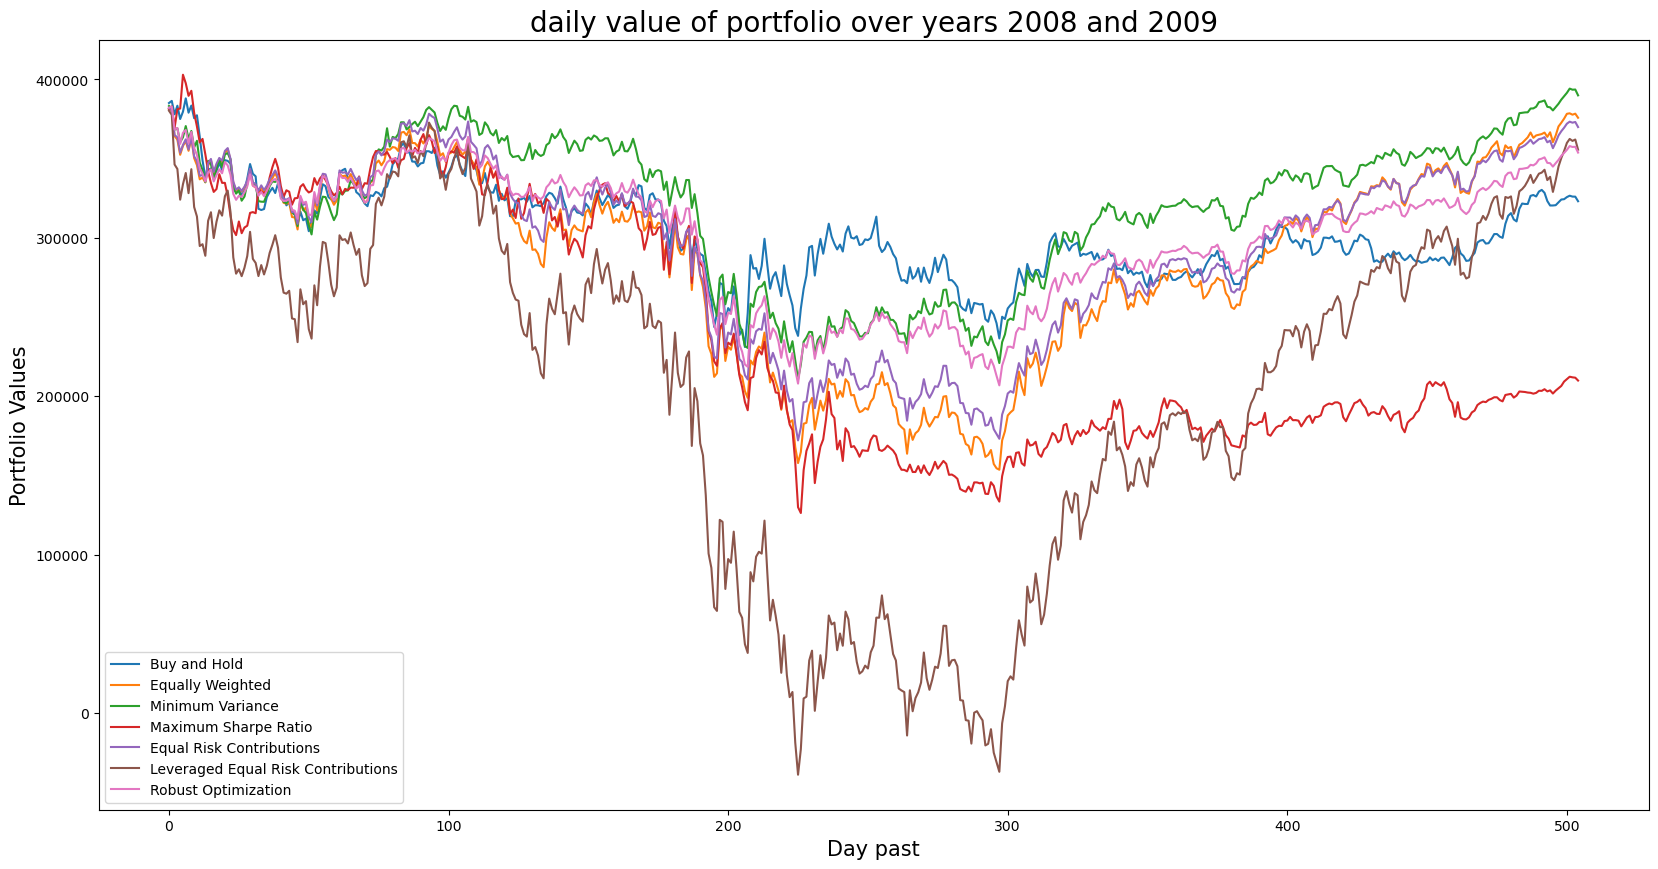

In [12]:
plt.figure(figsize=(20,10))
plt.plot(portf_value[0],label='Buy and Hold')
plt.plot(portf_value[1],label='Equally Weighted')
plt.plot(portf_value[2],label='Minimum Variance')
plt.plot(portf_value[3],label='Maximum Sharpe Ratio')
plt.plot(portf_value[4],label='Equal Risk Contributions')
plt.plot(portf_value[5],label='Leveraged Equal Risk Contributions')
plt.plot(portf_value[6],label='Robust Optimization')
plt.title('daily value of portfolio over years 2008 and 2009',fontsize=20)
plt.xlabel('Day past',fontsize=15)
plt.ylabel('Portfolio Values',fontsize=15)
plt.legend()
plt.show()

### Maximum drawdown

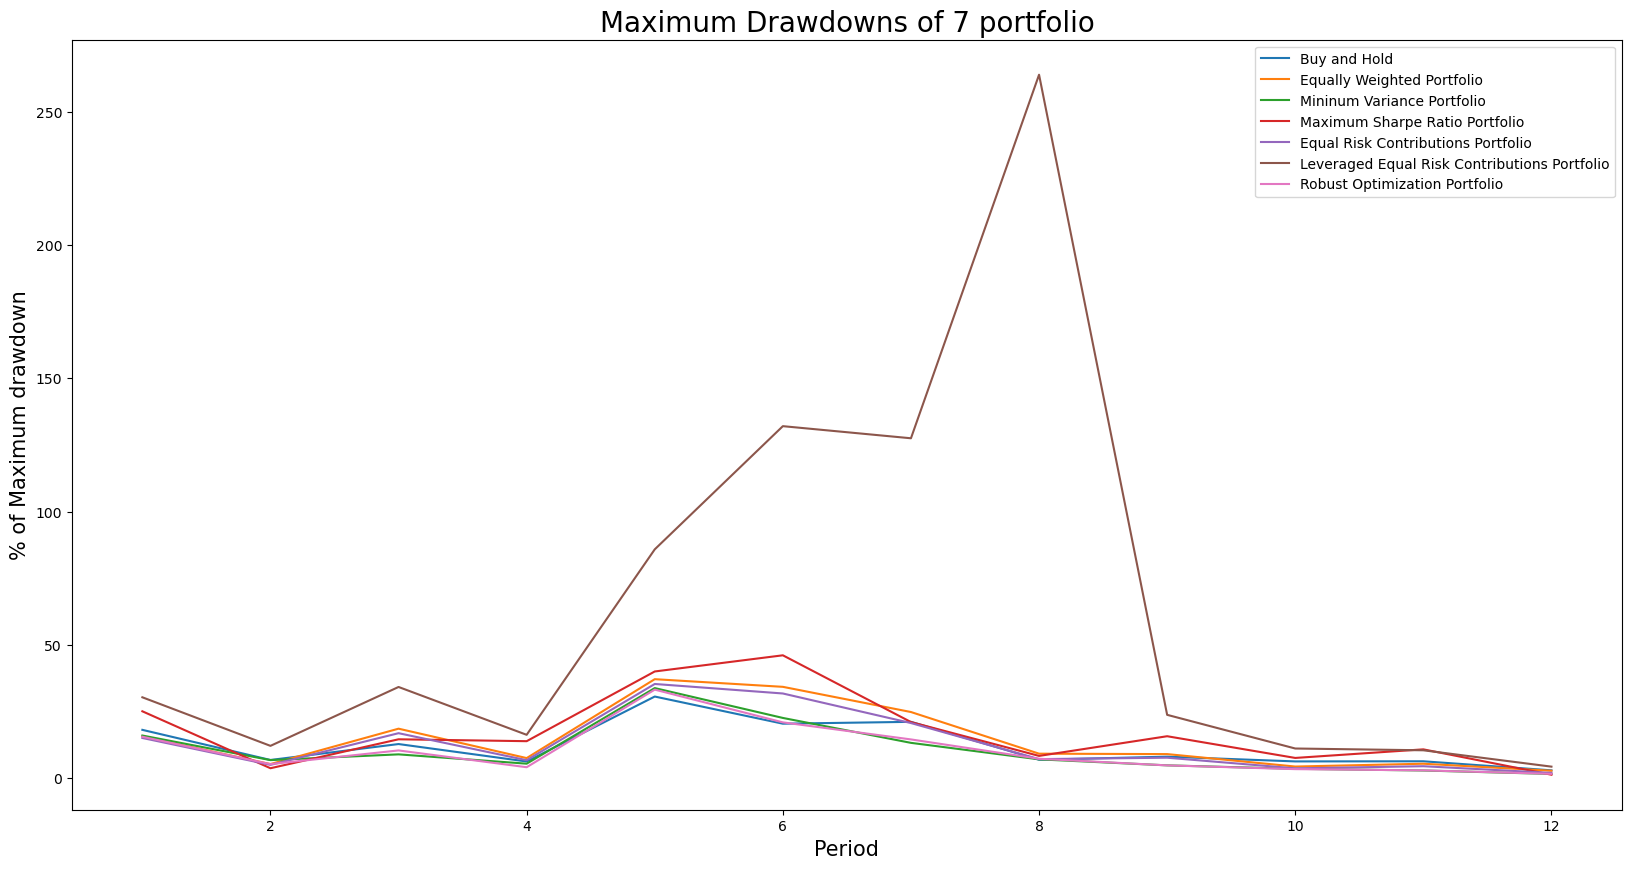

In [13]:
# dataframe of daily value of 7 portfolio
day_value = pd.DataFrame(portf_value[0].flatten())
for i in range(1,7):
    day_value[str(i)] = portf_value[i].flatten()
# seperate by period
period_value = []
for p in range(12):
    period_value.append(day_value.loc[504/12 * p : 504/12 * (p+1)])
# maximum drawdown
md_value = []
for p in range(12):
    dd_p = []
    for s in range(7):
        if s == 0:
            dd = (((period_value[p].loc[:,s] - period_value[p].loc[:,s].expanding().max()) / period_value[p].loc[:,s].expanding().max())*100).abs()
        else:
            dd = (((period_value[p].loc[:,str(s)] - period_value[p].loc[:,str(s)].expanding().max()) / period_value[p].loc[:,str(s)].expanding().max())*100).abs()
        dd_p.append(dd.max())
    md_value.append(dd_p)

# plot
columns=['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
plt.figure(figsize=(20,10))
for s in range(7):
    plt.plot(range(1, 13),np.array(md_value).transpose()[s],label=columns[s])

plt.title('Maximum Drawdowns of 7 portfolio',fontsize=20)
plt.xlabel('Period', fontsize=15)
plt.ylabel('% of Maximum drawdown', fontsize=15)
plt.legend()
plt.show()
# columns=['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']

### Plot three charts in Python for strategies 3, 4 and 7 to show dynamic changes in portfolio allocations 

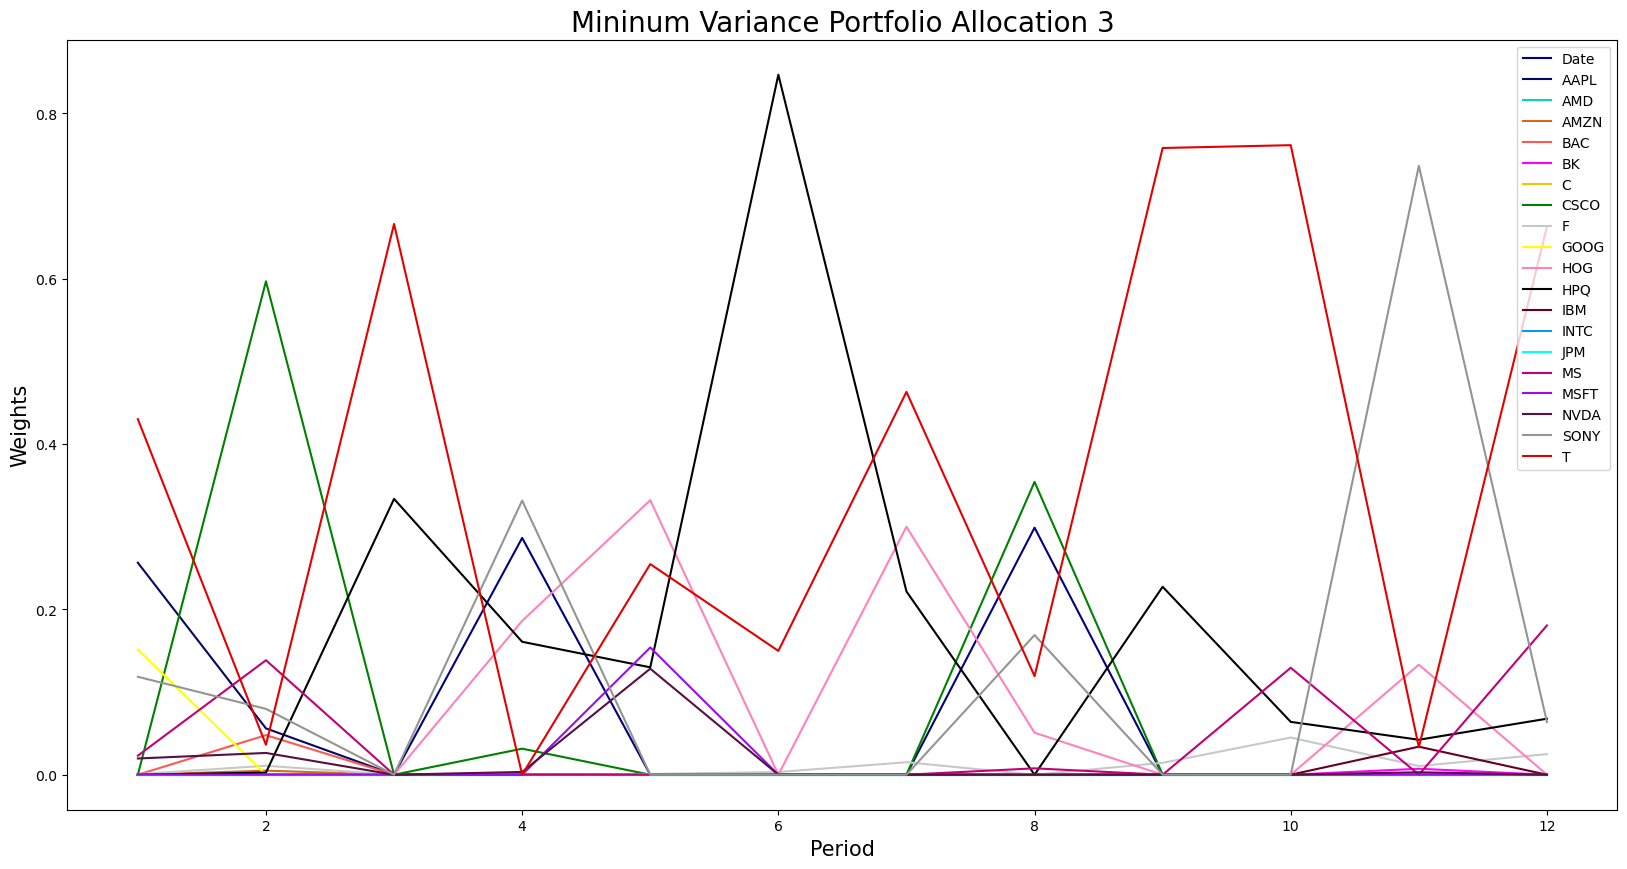

In [14]:
plt.figure(figsize=(20,10))
c_list=['#000080','#030764','#04D8B2','#D2691E','#FC5A50','#FF00FF','#FAC205','#008000','#C5C9C7','#FFFF00','#FF81C0','#000000','#650021','#069AF3','#00FFFF','#C20078','#9A0EEA','#580F41','#929591','#E50000','#9A0EEA']
for stock in range(20):
    # we want to store weight of each stock 1-20 for 12 periods
    w_period = []
    for period in range(1, N_periods+1):
        # strategy 3 at index 2
        w_all = x[2, period-1]/sum(x[2, period-1])
        w_period.append(w_all[stock])
    plt.plot(range(1, N_periods+1),w_period,label=df.columns[stock],color=c_list[stock])

plt.title('Mininum Variance Portfolio Allocation 3',fontsize=20)
plt.xlabel('Period',fontsize=15)
plt.ylabel('Weights',fontsize=15)
plt.legend()
plt.show()

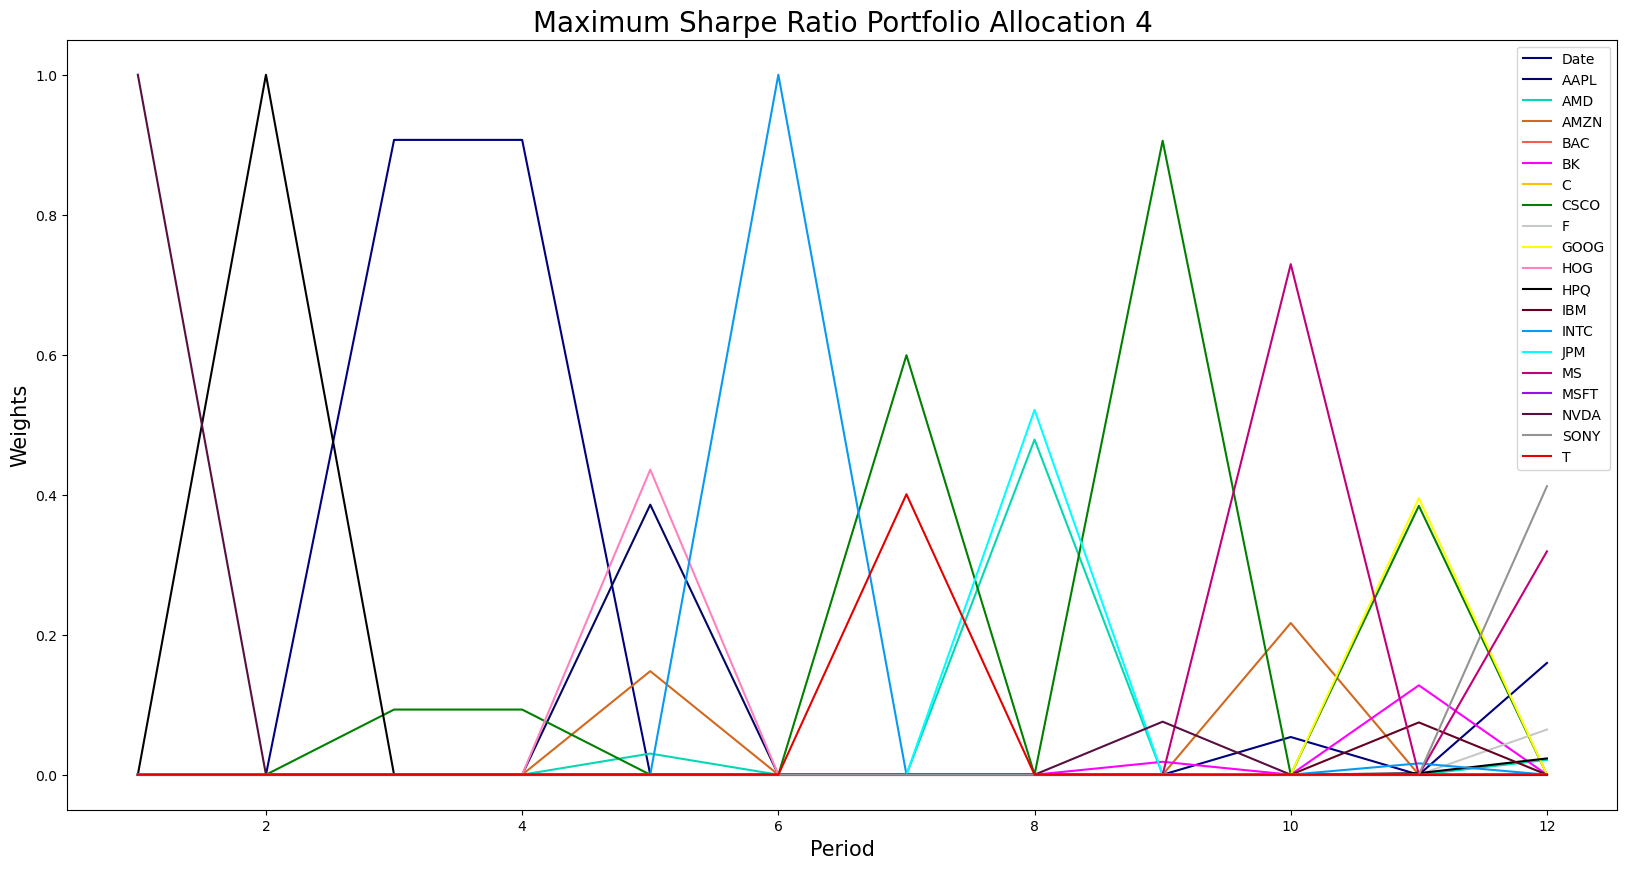

In [15]:
plt.figure(figsize=(20,10))
c_list=['#000080','#030764','#04D8B2','#D2691E','#FC5A50','#FF00FF','#FAC205','#008000','#C5C9C7','#FFFF00','#FF81C0','#000000','#650021','#069AF3','#00FFFF','#C20078','#9A0EEA','#580F41','#929591','#E50000','#9A0EEA']

for stock in range(20):
    # we want to store weight of each stock 1-20 for 12 periods
    w_period = []
    for period in range(1, N_periods+1):
        # strategy 4 at index 3
        w_all = x[3, period-1]/sum(x[3, period-1])
        w_period.append(w_all[stock])
    plt.plot(range(1, N_periods+1),w_period,label=df.columns[stock],color=c_list[stock])

plt.title('Maximum Sharpe Ratio Portfolio Allocation 4',fontsize=20)
plt.xlabel('Period',fontsize=15)
plt.ylabel('Weights',fontsize=15)
plt.legend()
plt.show()

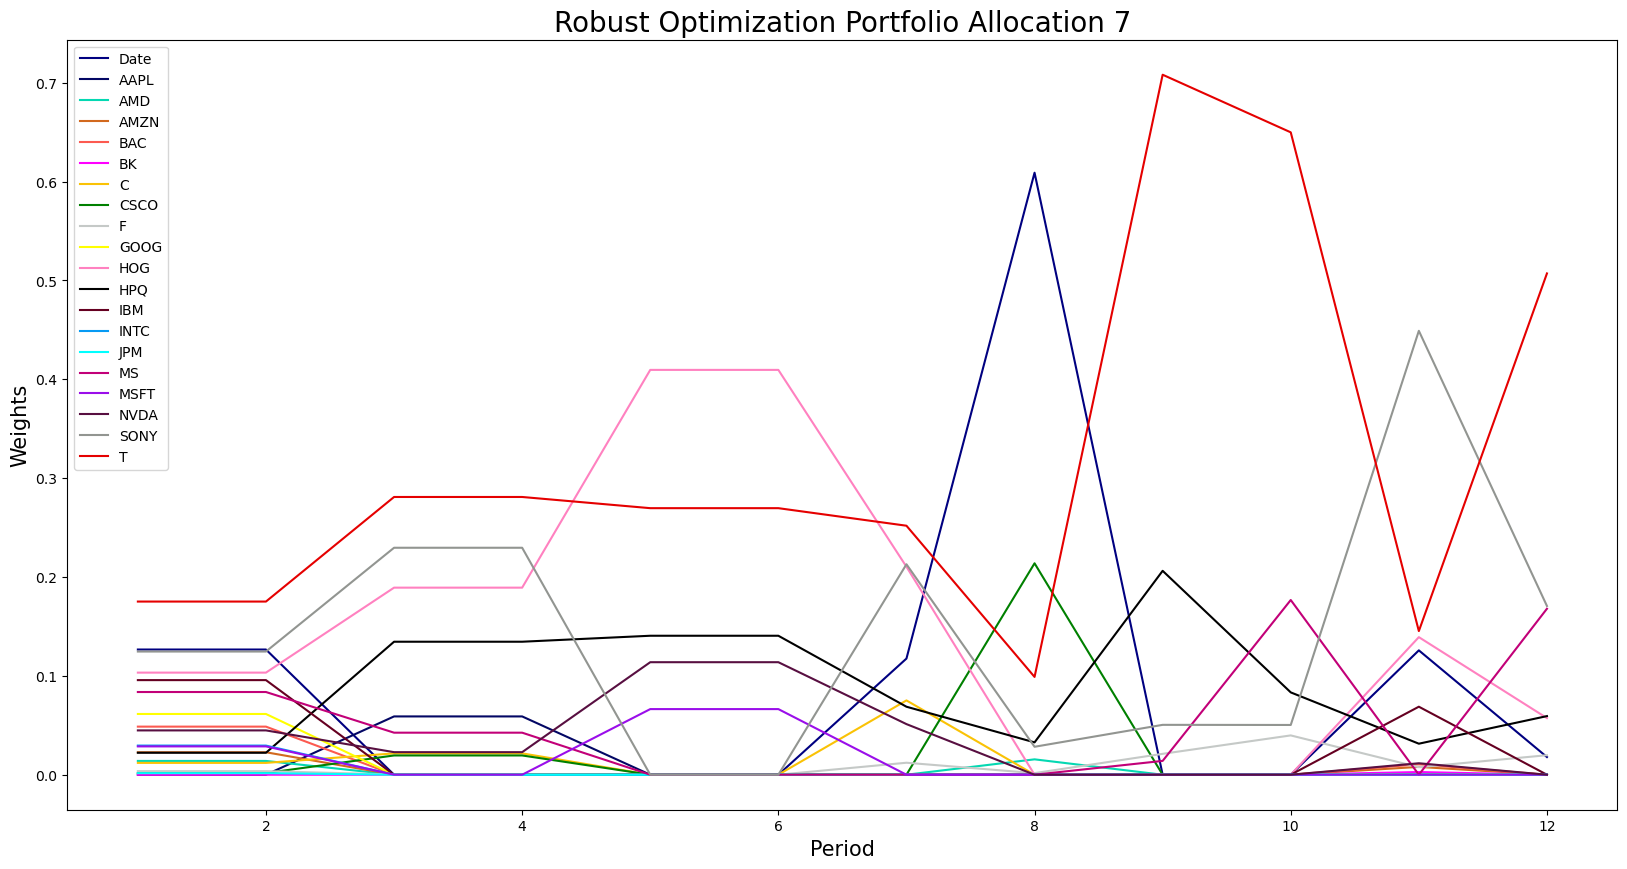

In [16]:
plt.figure(figsize=(20,10))
c_list=['#000080','#030764','#04D8B2','#D2691E','#FC5A50','#FF00FF','#FAC205','#008000','#C5C9C7','#FFFF00','#FF81C0','#000000','#650021','#069AF3','#00FFFF','#C20078','#9A0EEA','#580F41','#929591','#E50000','#9A0EEA']

for stock in range(20):
    # we want to store weight of each stock 1-20 for 12 periods
    w_period = []
    for period in range(1, N_periods+1):
        # strategy 7 at index 6
        w_all = x[6, period-1]/sum(x[6, period-1])
        w_period.append(w_all[stock])
    plt.plot(range(1, N_periods+1),w_period,label=df.columns[stock],color=c_list[stock])

plt.title('Robust Optimization Portfolio Allocation 7',fontsize=20)
plt.xlabel('Period',fontsize=15)
plt.ylabel('Weights',fontsize=15)
plt.legend()
plt.show()

## 3. Test your trading strategies for year 2022:
### Produce output for the 12 periods (year 2022)

In [17]:
# Input file
input_file_prices = 'Daily_closing_prices2022.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2021 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2021)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2021
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2020-2021 is 2.5%
r_rf = 0.025
# Annual risk-free rate for years 2008-2009 is 4.5%
r_rf2008_2009 = 0.045
# Annual risk-free rate for year 2022 is 3.75%
r_rf2022 = 0.0375

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
N_strat = 7  # comment this in your code
#N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_equal_risk_contr, strat_robust_optim]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 22:
       cur_year  = 22 + math.floor(period/7)
   else:
       cur_year  = 2022 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      ###################### Insert your code here ############################
      if cash[strategy, period-1] < 0:
            # propotion of each stock unit of share to total unit of share
            propotion = x[strategy, period-1] / sum(x[strategy, period-1])
            # value deduction of each stock
            v_deduction = abs(cash[strategy, period-1]) * propotion
            # unit of share deduction of each stock
            x_deduction = np.ceil(v_deduction/cur_prices)
            # deduct the share from optimal bunch
            x[strategy, period-1] = x[strategy, period-1] - x_deduction
            # new cost - transaction cost is 0.5% of the traded volume
            new_cost = 0.005 * np.dot(cur_prices , abs(x[strategy, period-1]-curr_positions))
            # total portfolio value
            if cash[5,0]<0:
                port_value = 2*(np.dot(cur_prices,curr_positions) + curr_cash)
            else:
                port_value = np.dot(cur_prices,curr_positions) + curr_cash
            # modify cash - cash flow is the difference btw
            # portfolio value before re-balancing and 
            # value of portfolio after re-balancing plus the transaction fees
            cash[strategy, period-1] = port_value - (np.dot(cur_prices,x[strategy, period-1]) + new_cost)
        

      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      # modify portfolio value for leverage equal risk
      if strategy == 5:
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1)) - init_value
      else:
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
        
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))

      
   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)



Initial portfolio value = $ 890077.15


Period 1: start date 01/03/2022, end date 02/28/2022
  Strategy "Buy and Hold", value begin = $ 890077.15, value end = $ 924072.93
  Strategy "Equally Weighted Portfolio", value begin = $ 881997.57, value end = $ 802549.65
  Strategy "Mininum Variance Portfolio", value begin = $ 885877.61, value end = $ 863404.89
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 881222.74, value end = $ 800309.12
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 882551.39, value end = $ 815422.86
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 879137.35, value end = $ 744692.74
  Strategy "Robust Optimization Portfolio", value begin = $ 883675.91, value end = $ 828053.68

Period 2: start date 03/01/2022, end date 04/29/2022
  Strategy "Buy and Hold", value begin = $ 921940.14, value end = $ 807230.89
  Strategy "Equally Weighted Portfolio", value begin = $ 783067.12, value end = $ 705796.90
  Strategy "Mininum

### Plot one chart in Python that illustrates the daily value of your portfolio

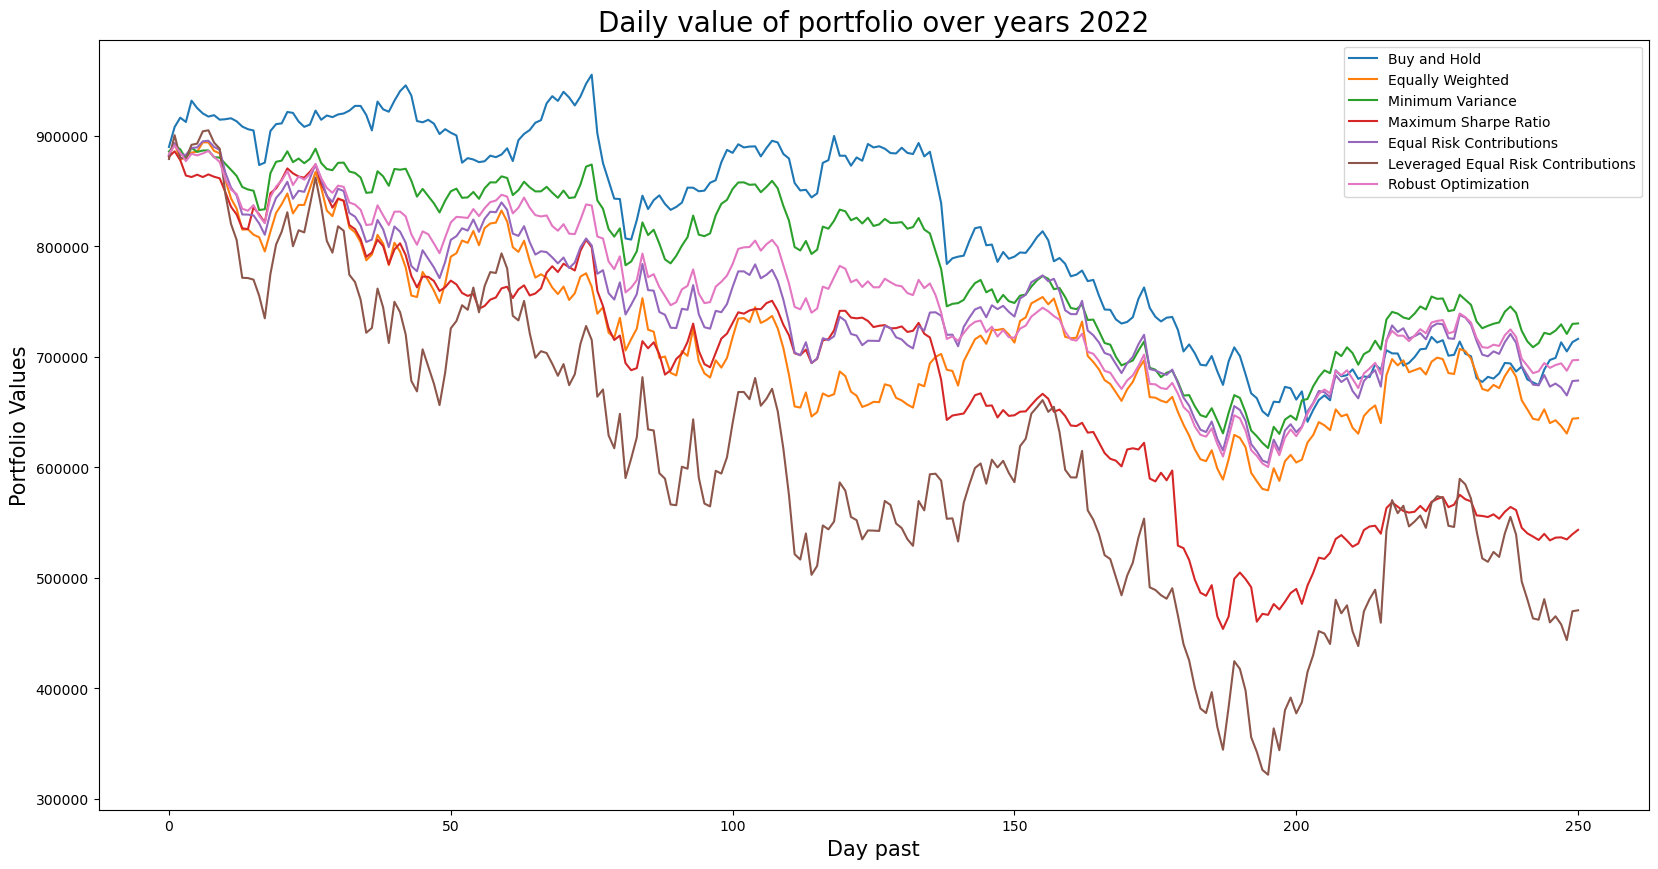

In [18]:
plt.figure(figsize=(20,10))
plt.plot(portf_value[0],label='Buy and Hold')
plt.plot(portf_value[1],label='Equally Weighted')
plt.plot(portf_value[2],label='Minimum Variance')
plt.plot(portf_value[3],label='Maximum Sharpe Ratio')
plt.plot(portf_value[4],label='Equal Risk Contributions')
plt.plot(portf_value[5],label='Leveraged Equal Risk Contributions')
plt.plot(portf_value[6],label='Robust Optimization')
plt.title('Daily value of portfolio over years 2022',fontsize=20)
plt.xlabel('Day past',fontsize=15)
plt.ylabel('Portfolio Values',fontsize=15)
plt.legend()
plt.show()

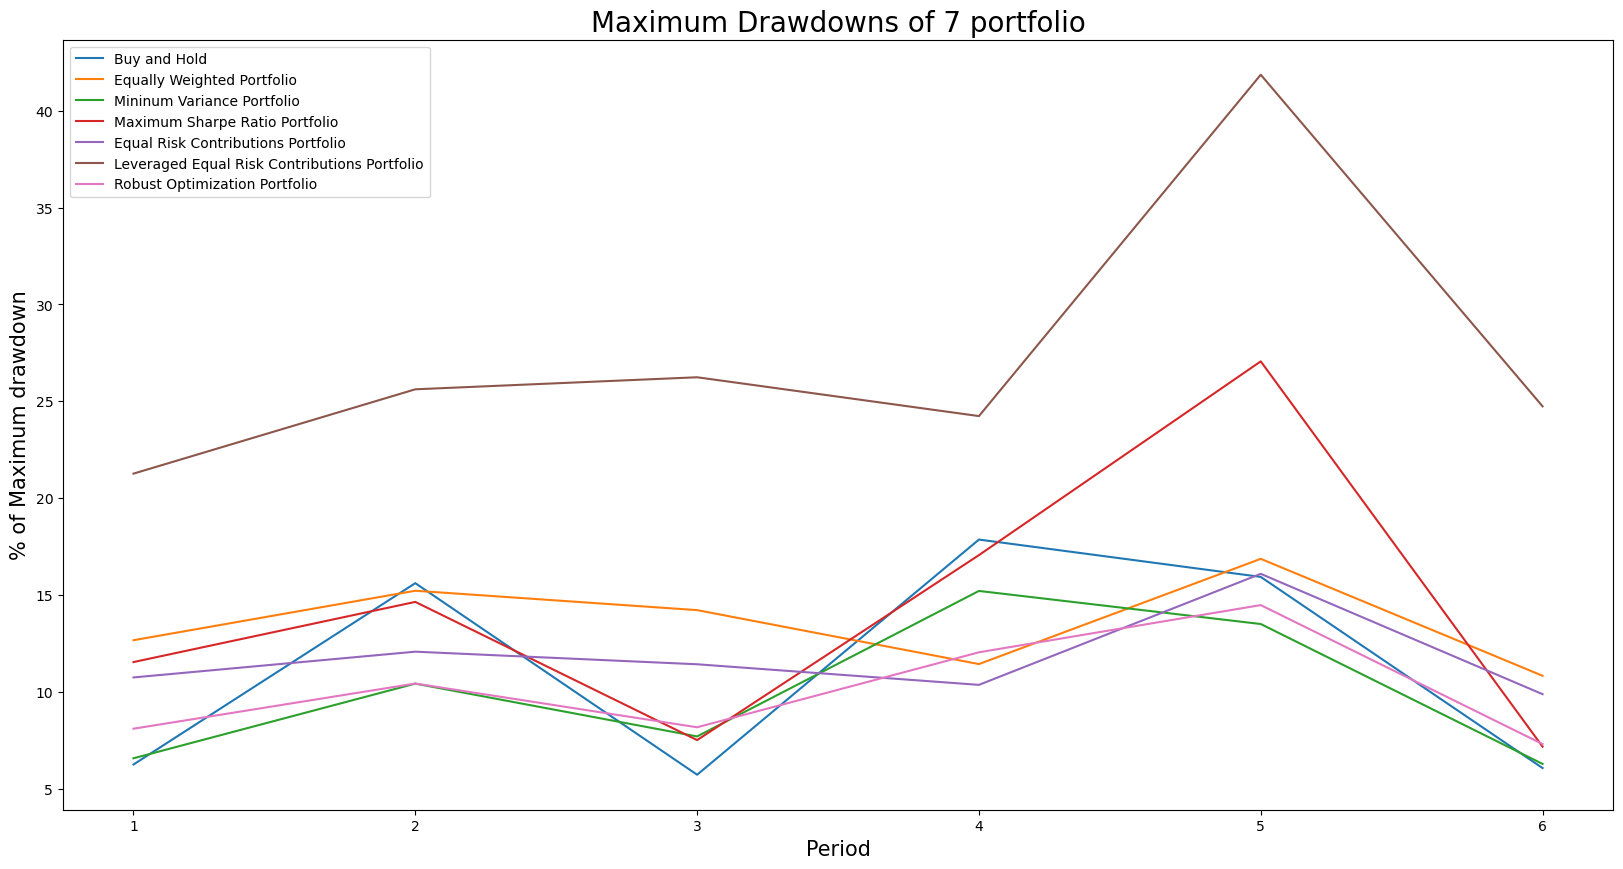

In [19]:
# dataframe of daily value of 7 portfolio
day_value = pd.DataFrame(portf_value[0].flatten())
for i in range(1,7):
    day_value[str(i)] = portf_value[i].flatten()
# seperate by period
period_value = []

for p in range(6):
    if p == 5:
        period_value.append(day_value.loc[round(250/6) * p :])
    else:
        period_value.append(day_value.loc[round(250/6) * p : round(250/6) * (p+1)])

# maximum drawdown
md_value = []
for p in range(6):
    dd_p = []
    for s in range(7):
        if s == 0:
            dd = (((period_value[p].loc[:,s] - period_value[p].loc[:,s].expanding().max()) / period_value[p].loc[:,s].expanding().max())*100).abs()
        else:
            dd = (((period_value[p].loc[:,str(s)] - period_value[p].loc[:,str(s)].expanding().max()) / period_value[p].loc[:,str(s)].expanding().max())*100).abs()
        dd_p.append(dd.max())
    md_value.append(dd_p)

# plot
columns=['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
plt.figure(figsize=(20,10))
for s in range(7):
    plt.plot(range(1, 7),np.array(md_value).transpose()[s],label=columns[s])

plt.title('Maximum Drawdowns of 7 portfolio',fontsize=20)
plt.xlabel('Period', fontsize=15)
plt.ylabel('% of Maximum drawdown', fontsize=15)
plt.legend()
plt.show()
# columns=['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']